In [1]:
%matplotlib inline

import pathlib
from pprint import pprint

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import numpy as np
import scipy as sp
import scipy.spatial.distance
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
from skimage import color
from skimage import feature

In [2]:
class Classifier(object):
    def __init__(self, name=''):
        self.y_score = []
        self.y_true = []
        self.name = name
        
    def extract(self, img):
        pass
    
    def score(self, pre, cur):
        pass
    
    def fit(self, name, pbar=True):
        frame_dir = pathlib.Path('./{}_out/'.format(name))
        frame_paths = sorted(frame_dir.glob('*.jpg'))
        n_frames = len(frame_paths)
        truth = './{}_ground.txt'.format(name)

        self.y_true = np.zeros(len(frame_paths), dtype=np.int32)
        with open(truth, 'r') as f:
            for line in f.readlines()[4:]:
                if '~' in line:
                    fs, fe = map(int, line.split('~'))
                    self.y_true[fs:fe + 1] = 1
                else:
                    self.y_true[int(line)] = 1
                    
        if pbar:
            frame_paths = tqdm(frame_paths)
                   
        self.y_score = np.zeros(len(frame_paths), dtype=np.float32)
        pre_feature = None
        for idx, path in enumerate(frame_paths):
            img = Image.open(path)
            cur_feature = self.extract(img)
            if idx >= 1:
                self.y_score[idx] = self.score(pre_feature, cur_feature)
            pre_feature = cur_feature
    
    def plot(self, ax, fill=False):
        pr, re, th = metrics.precision_recall_curve(self.y_true, self.y_score)
        ap = metrics.average_precision_score(self.y_true, self.y_score)
        label = self.name + ' (AP = {:.3f})'.format(ap)

        if fill:
            ax.step(re, pr, where='post', color='k')
            ax.fill_between(re, pr, step='post', alpha=0.5, color='teal')
            ax.set_title(label)
        else:
            ax.step(re, pr, where='post', label=label)

        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 1.0)

        df = pd.DataFrame({
            'th': th,
            'pr': pr[:-1],
            're': re[:-1]
        })    
        return df, ap
    
    def ap(self):
        pr, re, th = metrics.precision_recall_curve(self.y_true, self.y_score)
        ap = metrics.average_precision_score(self.y_true, self.y_score)
        return ap

In [3]:
class GreyHistClassifier(Classifier):
    def __init__(self, name, dist_func):
        super().__init__(name)
        self.dist_func = dist_func
    
    def extract(self, img):
        img = img.convert('L')
        img = np.array(img) / 255
        return np.histogram(img, bins=16, density=True)[0]
    
    def score(self, pre, cur):
        return self.dist_func(pre, cur)

In [4]:
class RgbHistClassifier(Classifier):
    def __init__(self, name, dist_func):
        super().__init__(name)
        self.dist_func = dist_func
    
    def extract(self, img):
        img = img.convert('RGB')
        img = np.array(img) / 255
        img = img.reshape((-1, 3))
        return np.histogramdd(img, bins=6, normed=True)[0].flatten()
    
    def score(self, pre, cur):
        return self.dist_func(pre, cur)

In [5]:
class HsvHistClassifier(Classifier):
    def __init__(self, name, dist_func):
        super().__init__(name)
        self.dist_func = dist_func
    
    def extract(self, img):
        img = img.convert('HSV')
        img = np.array(img) / 255
        img = img.reshape((-1, 3))
        return np.histogramdd(img, bins=(8, 4, 4), normed=True)[0].flatten()
    
    def score(self, pre, cur):
        return self.dist_func(pre, cur)

In [6]:
class BlockGreyHistClassifier(Classifier):
    def __init__(self, name, dist_func):
        super().__init__(name)
        self.dist_func = dist_func
        
    def split_to_blocks(self, img, nrows=2, ncols=2):
        res = []
        rows = np.vsplit(img, nrows)
        for row in rows:
            res.extend(np.hsplit(row, ncols))
        return np.array(res)
    
    def get_hist(self, img):
        return np.histogram(img, bins=16, density=True)[0]
    
    def extract(self, img):
        img = img.convert('L')
        img = np.array(img) / 255
        blocks = self.split_to_blocks(img)
        return np.concatenate([self.get_hist(b) for b in blocks])
    
    def score(self, pre, cur):
        return self.dist_func(pre, cur)

In [7]:
class BlockRgbHistClassifier(Classifier):
    def __init__(self, name, dist_func):
        super().__init__(name)
        self.dist_func = dist_func
        
    def split_to_blocks(self, img, nrows=2, ncols=2):
        res = []
        rows = np.vsplit(img, nrows)
        for row in rows:
            res.extend(np.hsplit(row, ncols))
        return np.array(res)
    
    def get_hist(self, img):
        img = img.reshape((-1, 3))
        return np.histogramdd(img, bins=6, normed=True)[0].flatten()
    
    def extract(self, img):
        img = img.convert('RGB')
        img = np.array(img) / 255
        blocks = self.split_to_blocks(img)
        return np.concatenate([self.get_hist(b) for b in blocks])
    
    def score(self, pre, cur):
        return self.dist_func(pre, cur)

In [8]:
class BlockHsvHistClassifier(Classifier):
    def __init__(self, name, dist_func):
        super().__init__(name)
        self.dist_func = dist_func
        
    def split_to_blocks(self, img, nrows=2, ncols=2):
        res = []
        rows = np.vsplit(img, nrows)
        for row in rows:
            res.extend(np.hsplit(row, ncols))
        return np.array(res)
    
    def get_hist(self, img):
        img = img.reshape((-1, 3))
        return np.histogramdd(img, bins=(8, 4, 4), normed=True)[0].flatten()
    
    def extract(self, img):
        img = img.convert('HSV')
        img = np.array(img) / 255
        blocks = self.split_to_blocks(img)
        return np.concatenate([self.get_hist(b) for b in blocks])
    
    def score(self, pre, cur):
        return self.dist_func(pre, cur)

In [9]:
class BlockStatClassifier(Classifier):
    def __init__(self, name):
        super().__init__(name)
        
    def split_to_blocks(self, img, nrows=4, ncols=4):
        res = []
        rows = np.vsplit(img, nrows)
        for row in rows:
            res.extend(np.hsplit(row, ncols))
        return np.array(res)
    
    def get_mean_var(self, img):
        return (np.mean(img), np.var(img))
    
    def extract(self, img):
        img = img.convert('L')
        img = np.array(img) / 255
        blocks = self.split_to_blocks(img)
        ms = [np.mean(b) for b in blocks]
        vs = [np.var(b) for b in blocks]
        return ms, vs
    
    def score(self, pre, cur):     
        m1s, v1s = pre
        m2s, v2s = cur
        n_blocks = len(m1s)
        diffs = np.zeros(n_blocks, dtype=np.float32)
        for i in range(n_blocks):
            m1, v1 = m1s[i], v1s[i]
            m2, v2 = m2s[i], v2s[i]
            nem = ((v1 + v2) / 2 + ((m1 - m2) / 2)**2)**2
            den = (v1 * v2)
            diffs[i] = nem / den
        return np.sum(diffs > 1.01)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=19), HTML(value='')))

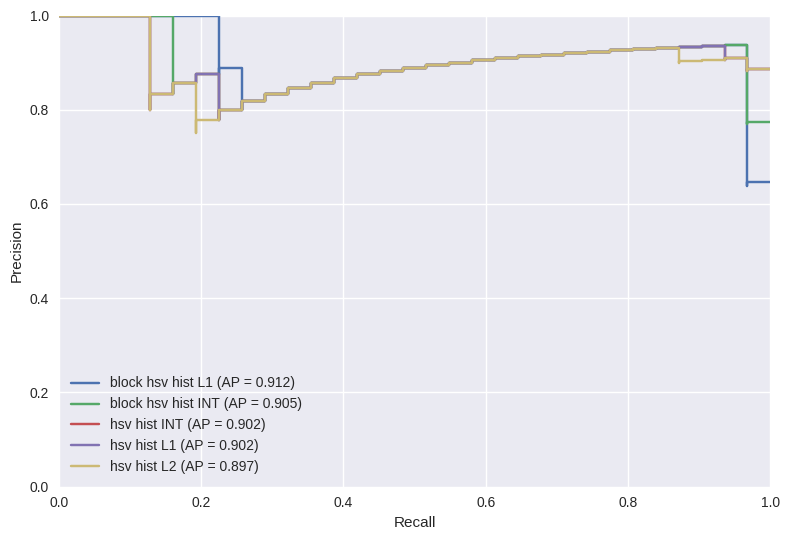

HBox(children=(IntProgress(value=0, max=19), HTML(value='')))

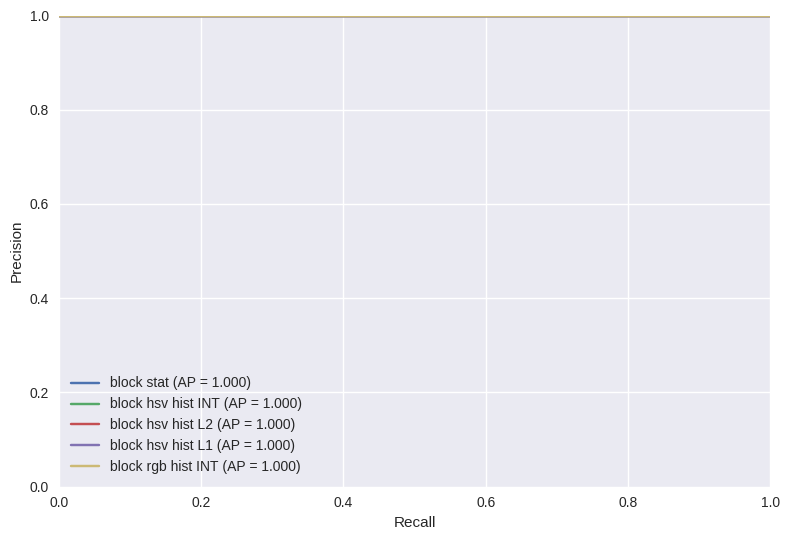

HBox(children=(IntProgress(value=0, max=19), HTML(value='')))

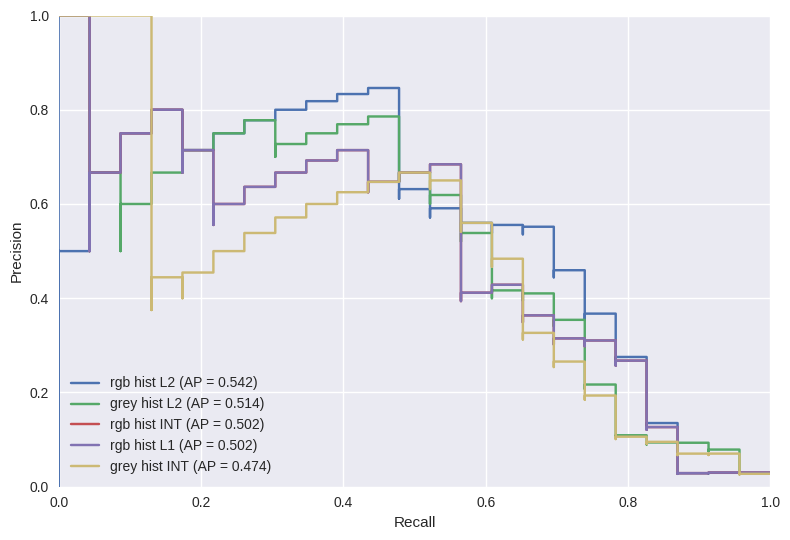

In [10]:
import csv

L1 = scipy.spatial.distance.cityblock
L2 = scipy.spatial.distance.euclidean
INT = lambda h1, h2: 1 - np.sum(np.minimum(h1, h2)) / np.sum(h2)

classifiers = [
    GreyHistClassifier('grey hist L1', L1),
    GreyHistClassifier('grey hist L2', L2),
    GreyHistClassifier('grey hist INT', INT),
    RgbHistClassifier('rgb hist L1', L1),
    RgbHistClassifier('rgb hist L2', L2),
    RgbHistClassifier('rgb hist INT', INT),
    HsvHistClassifier('hsv hist L1', L1),
    HsvHistClassifier('hsv hist L2', L2),
    HsvHistClassifier('hsv hist INT', INT),
    BlockGreyHistClassifier('block grey hist L1', L1),
    BlockGreyHistClassifier('block grey hist L2', L2),
    BlockGreyHistClassifier('block grey hist INT', INT),
    BlockRgbHistClassifier('block rgb hist L1', L1),
    BlockRgbHistClassifier('block rgb hist L2', L2),
    BlockRgbHistClassifier('block rgb hist INT', INT),
    BlockHsvHistClassifier('block hsv hist L1', L1),
    BlockHsvHistClassifier('block hsv hist L2', L2),
    BlockHsvHistClassifier('block hsv hist INT', INT),
    BlockStatClassifier('block stat')
]

for ds in tqdm(['friends', 'news', 'soccer']):
    res = []
    for i in tqdm(range(len(classifiers))):
        classifiers[i].fit(ds, pbar=False)
        res.append([classifiers[i].ap(), i])
        
    res = sorted(res, reverse=True)
    
    with open(ds + '.csv', 'w') as f:
        fieldnames = ['name', 'ap']
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for ap, i in res:
            writer.writerow({'name': classifiers[i].name, 'ap': ap})
    
    fig, ax = plt.subplots(dpi=100)
    for ap, i in res[:5]:
        classifiers[i].plot(ax)
    ax.legend(loc=3)
    fig.tight_layout()
    plt.show()